Notebook to try various baseline upscaling estimates

In [1]:
## Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
import dask_geopandas as dgpd
import statsmodels as sm
from statsmodels.formula.api import ols
from latlon_utils import get_climate, get_data_dir
import xarray as xr
import rioxarray
import cdsapi
import urllib3
import cartopy.crs as ccrs
import cartopy

# import powerlaw

analysis_dir = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/'
# roi_pth = '/Volumes/thebe/PAD2019/classification_training/ROI-analysis/ROI-analysis_albers.shp' # for small UAVSAR rois
season = 'jja' # or 'ann'
maxArea = 5000 # km2 include only lakes less than this for calc

###### vars
''' Vars 'dataset', 'roi_region', 'run' are used to generate output filename.'''
###########
# HL vars
# dataset = 'HL'
# variables = {'id_':'Hylak_id', 'gridcell_':'BAWLDCell_', 'area_':'Shp_Area', 'long_':'BAWLDLong', 'lat_':'BAWLDLat'} # Note: need t o join in lat/long
# gdf_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp' # HL clipped to BAWLD
# # gdf_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD_roiNAHL.shp' # HL clipped to BAWLD and WBD-NAHL
# useROI = False
# roi_region = 'BAWLD' #'WBD' # 'Baker' # PAD, Daring, YF
# run=7
# roi_pth = '/Volumes/thebe/Other/Feng-High-res-inland-surface-water-tundra-boreal-NA/edk_out/WBD_convex_hull.shp' # for WBD roi
# areaConversionFactor = 1 # because area already in m2
# runNote = 'Trying to replicate run 00... success!'


## WBD vars
# dataset = 'WBD'
# # variables = {'id_':'OBJECTID', 'gridcell_':'BAWLDCell_', 'area_':'Area', 'long_':'BAWLDLong', 'lat_':'BAWLDLat'} # if using joined BAWLD
# variables = {'id_':'OBJECTID', 'gridcell_':'Cell_ID', 'area_':'Area', 'long_':'Long', 'lat_':'Lat'}
# gdf_pth = '/Volumes/thebe/Other/Feng-High-res-inland-surface-water-tundra-boreal-NA/edk_out/fixed_geoms/WBD.shp' # '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/WBD_jnBAWLD.shp' # WBD NOTE: next run, use pre-joined and de-duplicated WBD
# useROI = True
# roi_region = 'WBD_BAWLD' # WBD intersect BAWLD
# run=4
# roi_pth = '/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip'
# areaConversionFactor = 1 # because area already in m2
# runNote = 'No additional notes.'

## Sheng vars
# dataset = 'Sheng'
# variables = {'id_':'SID', 'gridcell_':'Cell_ID', 'area_':'area', 'long_':'Long', 'lat_':'Lat'}
# gdf_pth = [f'/Volumes/thebe/Other/Sheng-Arctic-lakes/edk_out/UCLA_ArcticLakes15_{l}.shp' for l in ['AS', 'EU', 'NA']]
# useROI = True
# roi_region = 'BAWLD' # WBD intersect BAWLD
# run=6
# roi_pth = '/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip'
# areaConversionFactor = 1e6 # area is in m2, want km2
# runNote = 'No additional notes.'

## Sheng vars (for intersection with WBD and BAWLD)
dataset = 'Sheng'
variables = {'id_':'SID', 'gridcell_':'Cell_ID', 'area_':'area', 'long_':'Long', 'lat_':'Lat'}
gdf_pth = '/Volumes/thebe/Other/Sheng-Arctic-lakes/edk_out/clips/UCLA_ArcticLakes15_NA_WBD_BAWLD.shp'
useROI = True
roi_region = 'WBD_BAWLD' #'BAWLD' # WBD intersect BAWLD
run=8
roi_pth = '/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip'
areaConversionFactor = 1e6 # area is in m2, want km2
runNote = 'HL in BAWLD-WBD domain for comparison'
################ auto update vars
#################################

## Def output paths
joined_clim_dir = os.path.join(analysis_dir, 'joined_climate', f'run{run:02}')
summ_file_pth = os.path.join(joined_clim_dir, f'{dataset}_sub{roi_region}_clim_summ.csv')
logFile_pth = os.path.join(joined_clim_dir, f'logfile_run{run:02}.txt')

## Make dirs
os.makedirs(joined_clim_dir, exist_ok=True)

/var/folders/rv/sn0kln2103b9fs4xl56n3w7w0000gn/T/ipykernel_93286/4026541184.py:7: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopanda

## Start with Kuhn 2021 regression equations from BAWLD-CH4.

### Try to replicate coefficients

In [35]:
## Load
df = pd.read_csv('/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD-CH4/data/ek_out/archive/BAWLD_CH4_Aquatic.csv', 
    encoding = "ISO-8859-1", dtype={'CH4.E.FLUX ':'float'}, na_values='-')
len0 = len(df)

## Filter and pre-process
# df.query("SEASON == 'Icefree' ", inplace=True) # and `D.METHOD` == 'CH'
df.dropna(subset=['SA'], inplace=True) # 'CH4.D.FLUX', 'TEMP'

## if I want transformed y as its own var
df['CH4.D.FLUX.LOG'] = np.log10(df['CH4.D.FLUX']+1) 

## print filtering
len1 = len(df)
print(f'Filtered out {len0-len1} values ({len1} remaining).')
print(f'Variables: {df.columns}')

## View
df.head(2)

Filtered out 81 values (472 remaining).
Variables: Index(['ï»¿ID', 'NUM', 'STUDY', 'DATASET', 'YEAR', 'COUNTRY', 'SITE',
       'NUMBER.LAKES', 'LAT', 'LONG', 'ECOREGION', 'PERMA.ZONE', 'LAKE.TYPE',
       'BOTTOM', 'TALIK', 'SA', 'DEPTH', 'SEASON', 'YEAR.S', 'MONTH',
       'PATHWAY', 'D.METHOD', 'K600_EQ', 'K_REF', 'E.METHOD', 'E.LOCATION',
       'S.METHOD', 'D.DAYS', 'E.DAYS', 'LENGTH', 'CH4.D.FLUX', 'CH4.E.FLUX',
       'Seasonal.Diff.Flux', 'Seasonal.Ebul', 'Seasonal.Storage', 'IBS',
       'TEMP', 'DOC', 'PH', 'ICEFREE.DAYS', 'CLASS', 'SIZE', 'TYPE',
       'CD_Pcp_An', 'BIOME', 'GRID_T', 'NOTES', 'DOI', 'CH4.D.FLUX.LOG'],
      dtype='object')


,ï»¿ID,NUM,STUDY,DATASET,YEAR,COUNTRY,SITE,NUMBER.LAKES,LAT,LONG,...,ICEFREE.DAYS,CLASS,SIZE,TYPE,CD_Pcp_An,BIOME,GRID_T,NOTES,DOI,CH4.D.FLUX.LOG
0,1,1,Bartlett et al. 1992,WIK,1992,USA,Large lakes,20.0,60.46,-161.45,...,NaN,LL,L,NaN,522.45,11.0,-0.006,NaN,https://doi.org/10.1029/91JD00610,0.681241
1,2,1,Bartlett et al. 1992,WIK,1992,USA,Small lakes,20.0,60.46,-161.45,...,NaN,MLPe,M,Pe,522.45,11.0,-0.006,NaN,https://doi.org/10.1029/91JD00610,1.892095


Text(0.5, 0, 'Mg CH4 / m2 /day')

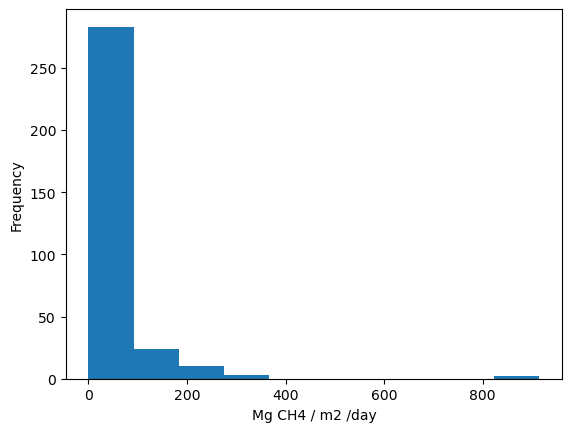

In [36]:
## Viz plot
df['CH4.D.FLUX'].plot.hist()
plt.xlabel('Mg CH4 / m2 /day')

## Find D vs E ratio

## Exploratory data analysis   

In [37]:
## Add total lake flux column (to match LSD.py)
dff = df.copy() # make a copy for filling nans and combined D + E
dff['CH4.E.FLUX'].fillna(dff['CH4.D.FLUX']*1.2, inplace=True)
dff['CH4.D.FLUX'].fillna(dff['CH4.E.FLUX']/1.2, inplace=True)
dff['CH4.DE.FLUX'] = dff['CH4.D.FLUX'] + dff['CH4.E.FLUX']

## Pre-process some more
dff['LAKE.TYPE'] = dff['LAKE.TYPE'].replace('PP/T', 'T') # set peatland pond/thermokarst = thermokarst for simplicity

## Filter and pre-process
# dff.query("SEASON == 'Icefree' ", inplace=True) # and `D.METHOD` == 'CH'
dff.dropna(subset=['SA', 'CH4.DE.FLUX'], inplace=True) # 'TEMP'


<Axes: xlabel='GRID_T', ylabel='CH4.DE.FLUX'>

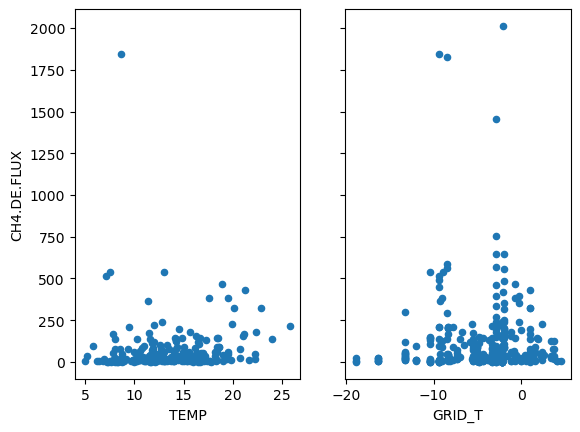

In [38]:
## Plot
_, ax = plt.subplots(1,2, sharey=True)
# df1.plot.scatter(x='TEMP', y='GRID_T')
dff.plot.scatter(x='TEMP', y='CH4.DE.FLUX', ax=ax[0])
dff.plot.scatter(x='GRID_T', y='CH4.DE.FLUX', ax=ax[1])

In [39]:
## How many missing entries for temp and GRID_T?
np.sum(np.isnan(dff.TEMP))
np.sum(np.isin(dff.MONTH, ''))
np.sum(np.isnan(dff.GRID_T))

35

### Plot metadata

<Axes: ylabel='Frequency'>

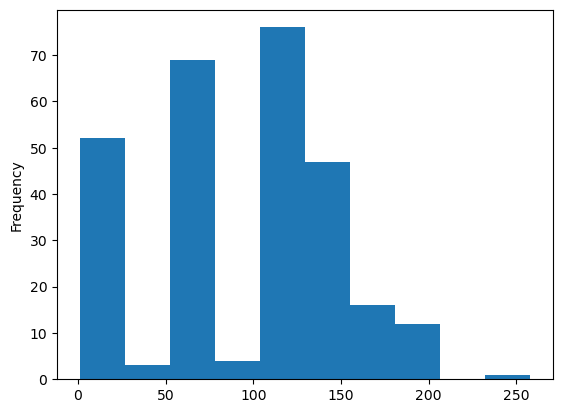

In [40]:
## How long were most studies?
dff.LENGTH.plot.hist()

.: Most studies lasted < 150 days with <= 3 measurements. So modeled monthly air temp would be hard to compute, unless I take the middle month or average of months.

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='D.DAYS', ylabel='Count'>

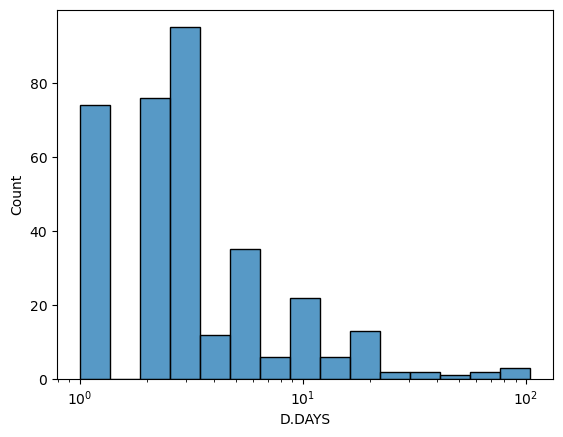

In [41]:
# dff['D.DAYS'].plot.hist()
sns.histplot(dff, x='D.DAYS', log_scale=10)

In [50]:
## How many unique years and months in BAWLD?
unq_yrs = np.unique(df[['YEAR']])
unq_yrs

array([1992, 1994, 1995, 1998, 1999, 2001, 2002, 2003, 2004, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020])

In [42]:
df[['LAT','LONG']]
df[['YEAR','MONTH']]

,YEAR,MONTH
0,1992,July-August
1,1992,July-August
2,1992,July-August
4,2004,July
5,2004,July
...,...,...
546,2017,July-August
549,2019,October-May
550,2019,October-May
551,2019,October-May


## Regression

In [43]:
## Linear models (regression) v0
formula1 = "np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + TEMP" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model1 = ols(formula=formula1, data=dff).fit() # uses water temp
formula2 = "np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + GRID_T" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model2 = ols(formula=formula2, data=dff).fit() # uses MAAT
formula3 = "np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + np.power(TEMP, 2)" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model3 = ols(formula=formula3, data=dff).fit() # uses MAAT

# print(f'R2: {model1.rsquared:0.3}')
model1.summary() # Their model uses 149 data points with adj r2 = 0.36

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     np.log10(Q('CH4.DE.FLUX') + 0.01)   R-squared:                       0.106
Model:                                           OLS   Adj. R-squared:                  0.099
Method:                                Least Squares   F-statistic:                     14.35
Date:                               Wed, 13 Sep 2023   Prob (F-statistic):           1.30e-06
Time:                                       10:58:46   Log-Likelihood:                -256.18
No. Observations:                                244   AIC:                             518.4
Df Residuals:                                    241   BIC:                             528.9
Df Model:                                          2                                         
Covariance Type:                           nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5402      0.161      3.345      0.001       0.222       0.858
np.log10(SA)    -0.0887      0.037     -2.378      0.018      -0.162      -0.015
TEMP             0.0507      0.011      4.506      0.000       0.029       0.073
==============================================================================
Omnibus:                       77.880   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              407.419
Skew:                          -1.156   Prob(JB):                     3.39e-89
Kurtosis:                       8.893   Cond. No.                         51.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
## Compare model using water temp vs MAAT. First column is after filtering by TEMP and ice-free. Second column is without and shows less difference bw variable.
model1.rsquared # 0.115 # 0.106 # water temp
model2.rsquared # 0.046 # 0.109 # MAAT
model3.rsquared # 0.116 # 0.108 # water temp squared - hardly an improvement! Justification for linear.
# TODO: model that uses monthly or daily air temp!

0.10640152655941582

In [6]:
## compare to HR16
bin_edges = [0, 0.001, 0.01, 0.1, 1, 10, 100, np.inf]
area_bins = pd.IntervalIndex.from_breaks(bin_edges, closed='left')
df['labels'] = pd.cut(df.SA, area_bins, right=False)

## Bin
group_means_d = df.groupby(['labels'])['CH4.D.FLUX'].mean() # 
group_means_e = df.groupby(['labels'])['CH4.E.FLUX'].mean() # 
group_sem_e = df.groupby(['labels'])['CH4.E.FLUX'].sem() # 

wAvg = lambda x: (np.nansum(x['CH4.D.FLUX'] * x['SA'])) / np.nansum(x['SA'])  # lambda to apply weighted mean
group_means_d_weighted = df.groupby(['labels']).apply(wAvg) # units mg CH4m−2d−1
group_sem_d = df.groupby(['labels'])['CH4.D.FLUX'].sem()

## Test if weighting fluxes within bin by lake area matters (it doesn't really)
pd.DataFrame({'Weighted': group_means_d_weighted, 'Unweighted': group_means_d})

,Weighted,Unweighted
labels,,
"[0.0, 0.001)",83.153513,81.345516
"[0.001, 0.01)",48.764551,57.821621
"[0.01, 0.1)",15.291354,21.735805
"[0.1, 1.0)",12.296279,22.443092
"[1.0, 10.0)",9.622905,11.667766
"[10.0, 100.0)",8.584530,9.420000
"[100.0, inf)",5.019685,4.675000


/tmp/ipykernel_23237/3690919346.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(labels) # =hr16_means_d.index


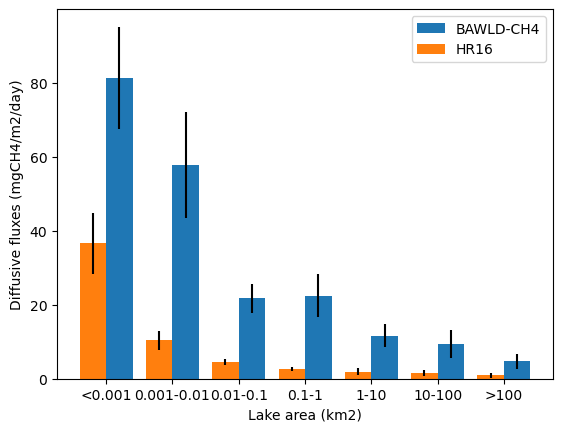

In [7]:
## Plot to view size bins ratios
## HR16
hr16_means_d = pd.Series([36.6, 10.4, 4.5, 2.6, 1.92, 1.60, 0.962], index=group_means_d.index)  # Units = mmol C /m2 /day converted to mg CH4/ m2/day
hr16_sem_d = pd.Series([8.18, 2.57, 0.80, 0.64, 0.96, 0.80, 0.64], index=group_means_d.index)

## Rosentreter et al. 2021
# r21_means_d = pd.Series([54.5, 31.1, 22.4, 9.9, 33.0, np.nan, np.nan], index=group_means_d.index)  # Units = mg CH4/ m2/day
r21_means_de = pd.Series([407.6, 228.8, 98.3, 62.5, 144.8, np.nan, np.nan], index=group_means_d.index)  # Units = mg CH4/ m2/day
r21_sem_de = pd.Series([238.0, 114.6, 39.3, 37.8, 191.6, np.nan, np.nan], index=group_means_d.index) # actually 95% CI

## Note: not lakes in BAWLD > 100 km2. df.query('SA > 100') --> empty df

## Plots
barWidth = 0.40
offset = 0.20
labels = ['dummy', '<0.001', '0.001-0.01', '0.01-0.1','0.1-1','1-10', '10-100', '>100']
plt.bar(x=np.arange(len(group_means_d))+offset, width=barWidth, height=group_means_d, alpha=1, label='BAWLD-CH4', yerr=group_sem_d)
plt.bar(x=np.arange(len(hr16_means_d))-offset, width=barWidth, height=hr16_means_d, alpha=1, label='HR16', yerr=hr16_sem_d)
plt.legend()
plt.ylabel('Diffusive fluxes (mgCH4/m2/day)')
plt.xlabel('Lake area (km2)')
plt.gca().set_xticklabels(labels) # =hr16_means_d.index
plt.show()


/tmp/ipykernel_23237/1649094610.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(labels[:-3]+['>10']) # =hr16_means_d.index


Text(0, 0.5, 'D+ E fluxes (mgCH4/m2/day)')

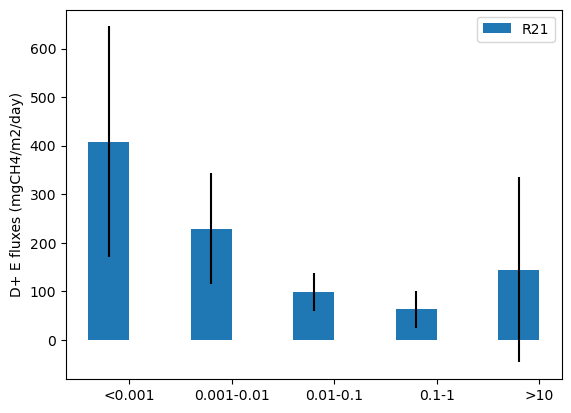

In [8]:
## Repeat for R21 (much higher values)
plt.bar(x=np.arange(len(r21_means_de))-offset, width=barWidth, height=r21_means_de, alpha=1, label='R21', yerr=r21_sem_de)
plt.legend()
plt.gca().set_xticklabels(labels[:-3]+['>10']) # =hr16_means_d.index
plt.ylabel('D+ E fluxes (mgCH4/m2/day)')


In [9]:
## Figure out ratio of first bin avg to rest

# drop upper bin to be consistent (since none in BAWLD after filtering)
group_means_d_drop = group_means_d[:-1]
b_ratio = group_means_d_drop[0] / group_means_d_drop[1:].mean() # bin ratio # try filtering [1:]

hr16_means_d_drop = hr16_means_d[:-1]
hr16_ratio = hr16_means_d_drop[0] / hr16_means_d_drop[1:].mean()

hr16_ratio_rep = hr16_means_d[0] / hr16_means_d[1:].mean()

r21_ratio = r21_means_de[0] / r21_means_de[1:].mean() # Note, they use fewer bins than others and include E, which tends to make the curve flatter

print(f'BAWLD ratio: {b_ratio:0.2}\nHR16 ratio: {hr16_ratio:0.2}\nR21 ratio: {r21_ratio:0.2}')
# print(f'Replicate HR16 stat: {hr16_ratio_rep:0.2%}')


BAWLD ratio: 3.3
HR16 ratio: 8.7
R21 ratio: 3.1


In [10]:
## V2: Figure out very small pond contrib to total flux for direct comparison w HR16

HR16_areas = np.array([334366, 406576, 675234, 984651, 782074, 597789, 2024016]) # for first bin: lower bound = 147763, upper = 861578
est_areas = np.array([7258, 34886, 117171, 264898, 296301, 210167, 440971])# my area estimates
group_rate_means_d = group_means_d * HR16_areas # units mg ch4 / day
group_rate_means_d_v2 = group_means_d * est_areas # units mg ch4 / day

b_ratio_fluxrate = group_rate_means_d[0] / group_rate_means_d.sum() # bin ratio of flux rates
b_ratio_fluxrate_v2 = group_rate_means_d_v2[0] / group_rate_means_d_v2.sum() # bin ratio of flux rates

print(f'BAWLD fluxrate ratio using HR16 areas: {b_ratio_fluxrate:0.2%}')
print(f'BAWLD fluxrate ratio using est areas: {b_ratio_fluxrate_v2:0.2%}\nHR16 ratio presented: 40.6%')

print(f'\nHR16 v small pond area ratio: {HR16_areas[0] / HR16_areas.sum():0.2%}')
print(f'My est v small pond area ratio: {est_areas[0] / est_areas.sum():0.2%}')

BAWLD fluxrate ratio using HR16 areas: 24.35%
BAWLD fluxrate ratio using est areas: 3.17%
HR16 ratio presented: 40.6%

HR16 v small pond area ratio: 5.76%
My est v small pond area ratio: 0.53%


/tmp/ipykernel_23237/333129865.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(labels) # =hr16_means_d.index


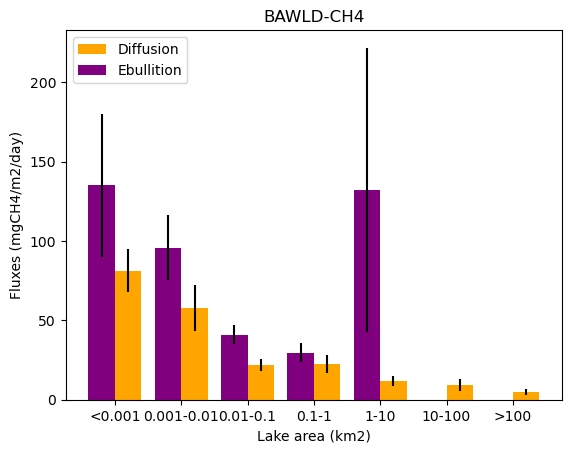

In [11]:
## Plots: compare BAWLD D vs E
barWidth = 0.40
offset = 0.20
labels = ['dummy', '<0.001', '0.001-0.01', '0.01-0.1','0.1-1','1-10', '10-100', '>100']


plt.bar(x=np.arange(len(group_means_d))+offset, height=group_means_d, width=barWidth, alpha=1, color='orange', label='Diffusion', yerr=group_sem_d)
plt.bar(x=np.arange(len(group_means_d))-offset, height=group_means_e, width=barWidth, alpha=1, color='purple', label='Ebullition', yerr=group_sem_e)

plt.legend()
plt.title('BAWLD-CH4')
plt.ylabel('Fluxes (mgCH4/m2/day)')
plt.xlabel('Lake area (km2)')
plt.gca().set_xticklabels(labels) # =hr16_means_d.index
plt.show()

## Lakes vs wl flux

In [7]:
## Re-load lakes, this time, don't filter by SA
df = pd.read_csv('/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD-CH4/data/ek_out/archive/BAWLD_CH4_Aquatic.csv', 
    encoding = "ISO-8859-1", dtype={'CH4.E.FLUX ':'float'}, na_values='-')
len0 = len(df)

## Filter and pre-process
df.query("SEASON == 'Icefree' ", inplace=True) # and `D.METHOD` == 'CH'

## print filtering
len1 = len(df)
print(f'Filtered out {len0-len1} values ({len1} remaining).')
print(f'Variables: {df.columns}')

Filtered out 72 values (481 remaining).
Variables: Index(['ï»¿ID', 'NUM', 'STUDY', 'DATASET', 'YEAR', 'COUNTRY', 'SITE',
       'NUMBER.LAKES', 'LAT', 'LONG', 'ECOREGION', 'PERMA.ZONE', 'LAKE.TYPE',
       'BOTTOM', 'TALIK', 'SA', 'DEPTH', 'SEASON', 'YEAR.S', 'MONTH',
       'PATHWAY', 'D.METHOD', 'K600_EQ', 'K_REF', 'E.METHOD', 'E.LOCATION',
       'S.METHOD', 'D.DAYS', 'E.DAYS', 'LENGTH', 'CH4.D.FLUX', 'CH4.E.FLUX',
       'Seasonal.Diff.Flux', 'Seasonal.Ebul', 'Seasonal.Storage', 'IBS',
       'TEMP', 'DOC', 'PH', 'ICEFREE.DAYS', 'CLASS', 'SIZE', 'TYPE',
       'CD_Pcp_An', 'BIOME', 'GRID_T', 'NOTES', 'DOI'],
      dtype='object')


In [8]:
## Load wl
df_terr = pd.read_csv('/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD-CH4/data/ek_out/BAWLD_CH4_Terrestrial.csv', 
    encoding = "ISO-8859-1", dtype={'CH4.E.FLUX ':'float'}, na_values='-')
len0 = len(df_terr)

## View
df_terr.head(2)

,RefID,Dataset,Reference,LatDec,LongDec,Site,SiteID,Country,ID,Ecosystem,...,Sedge,Sphag,Moss,Trees,Shrubs,Annual.Temp,TotalID,CD_Pcp_An,BIOME,DOI
0,1,Olefeldt,"Adamsen and King, 1993, Applied and Environmen...",54.72,-66.7,"Schefferville, Quebec, Canada",Schefferville,Canada,NaN,Subarctic Tundra,...,NaN,NaN,NaN,NaN,NaN,-4.6,ScheffervilleUpTundra,787.338,6.0,https://doi.org/10.1128/aem.59.2.485-490.1993
1,1,Olefeldt,"Adamsen and King, 1993, Applied and Environmen...",54.72,-66.7,"Schefferville, Quebec, Canada",Schefferville,Canada,NaN,Forest,...,A,A,A,D,D,-4.6,ScheffervilleBoreal,787.338,6.0,https://doi.org/10.1128/aem.59.2.485-490.1993


In [9]:
print('Means')
print(f"Aquatic: mean D: {df['CH4.D.FLUX'].mean():0.3}")
print(f"Aquatic: mean E: {df['CH4.E.FLUX'].mean():0.3}")
print(f"Terrestrial: mean: {df_terr['CH4Av'].mean():0.3}")
print('\nMedians')
print(f"Aquatic: median D: {df['CH4.D.FLUX'].median():0.3}")
print(f"Aquatic: median E: {df['CH4.E.FLUX'].median():0.3}")
print(f"Terrestrial: median: {df_terr['CH4Av'].median():0.3}")

Means
Aquatic: mean D: 42.2
Aquatic: mean E: 73.5
Terrestrial: mean: 53.3

Medians
Aquatic: median D: 12.6
Aquatic: median E: 21.5
Terrestrial: median: 22.8


In [10]:
## number of studies
print(f'{len(np.unique(df.STUDY))} aquatic studies *some from syntheses')
print(f'{len(np.unique(df_terr.Reference))} terrestrial studies')

62 aquatic studies *some from syntheses
123 terrestrial studies


In [11]:
## Means from marshes
marshes = df_terr.query('Class == "Marshes"')
print(f'{len(marshes)} marsh studies.')
print(f"Marshes: mean: {marshes['CH4Av'].mean():0.4}")
print(f"Marshes: median: {marshes['CH4Av'].median():0.4}")
print(f"Flux ratio (Marsh:OW, method 1): {marshes['CH4Av'].median()/(df['CH4.D.FLUX'].median() + df['CH4.E.FLUX'].median()):0.3}") # uses, D,E +/or combined DEP chamber flux

33 marsh studies.
Marshes: mean: 171.6
Marshes: median: 106.0
Flux ratio (Marsh:OW, method 1): 3.1


In [12]:
# Replicate Wik stat that DE = E*2.2
dff0 = df.dropna(subset=['CH4.E.FLUX', 'CH4.E.FLUX']) # hadn't filtered E earlier
dff0.shape
print(f"Ebullition accounts for {dff0['CH4.E.FLUX'].median() / (dff0['CH4.D.FLUX'] + dff0['CH4.E.FLUX']).median():0.3%} of total.")


Ebullition accounts for 40.888% of total.


< Here, I created CH4.DE.Flux>

In [ ]:

## Plot by wl type
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10, 4))
sns.boxplot(df_terr, x='Class', y='CH4Av', ax=ax[0], color='grey')
sns.boxplot(dff, x='LAKE.TYPE', y='CH4.DE.FLUX', ax=ax[1], color='grey') # x='labels'

## ylim
ax[0].set_ylim([-20, 800])

## labels
ax[0].set_ylabel('Methane flux ($mg\ CH_4\ /\ day$)')
ax[1].set_ylabel('')
# ax[1].set_xticklabels(['Glacial\npostglacial', 'Thermokarst', 'Peatland\nPond', 'Beaver\nPond', 'Unspecified'])
ax[1].set_xticklabels(['Thermokarst', 'Glacial\npostglacial', 'Beaver\nPond', 'Peatland\nPond', 'Unspecified'])
fig.set_tight_layout(tight=True)

/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.8, 1.0, 0.796078431372549), (0.8, 1.0, 0.796078431372549), (0.8, 1.0, 0.796078431372549), (0.8, 1.0, 0.796078431372549), (0.8, 1.0, 0.796078431372549), (0.8, 1.0, 0.796078431372549), (0.8, 1.0, 0.796078431372549)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.8, 1.0, 0.796078431372549), (0.8, 1.0, 0.796078431372549), (0.8, 1.0, 0.796078431372549), (0.8, 1.0, 0.796078431372549), (0.8, 1.0, 0.796078431372549)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


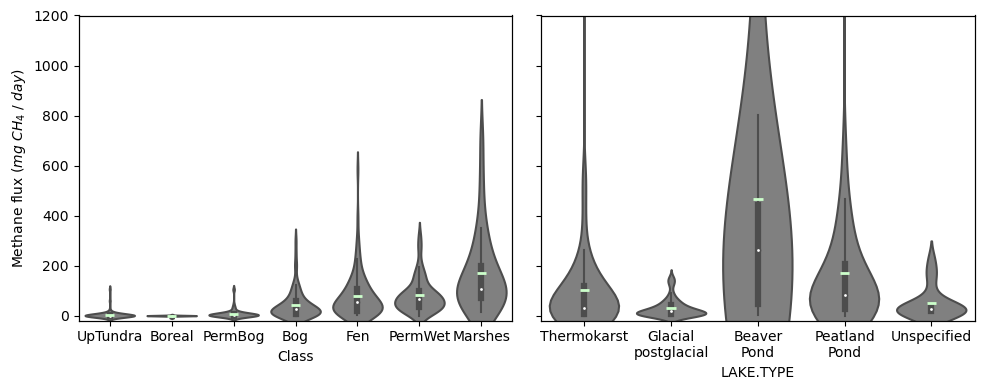

In [102]:
## Plot by wl type, but use violin plot and log y axis
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10, 4))
sns.violinplot(df_terr, x='Class', y='CH4Av', ax=ax[0], color='grey', scale='width', showmeans=False)
sns.violinplot(dff, x='LAKE.TYPE', y='CH4.DE.FLUX', ax=ax[1], color='grey', scale='width', showmeans=False, zorder=0) # x='labels'

## ADd means, since showmeans arg not working
ax0 = ax[0].twinx()
sns.pointplot(df_terr, x='Class', y='CH4Av', ax=ax0, linestyles='', errorbar=None, markers='_', color='#CCFFCB')
ax1 = ax[1].twinx()
sns.pointplot(dff, x='LAKE.TYPE', y='CH4.DE.FLUX', ax=ax1, linestyles='', errorbar=None, markers='_', color='#CCFFCB') # x='labels'

## ylim
ax[0].set_ylim([-20, 1200])
ax0.set_ylim(ax[0].get_ylim())
ax1.set_ylim(ax[1].get_ylim())

## hid ticks
for axis in [ax0, ax1]:
    axis.set_yticklabels([])
    axis.set_yticks([])
    axis.set_ylabel('')
## labels
ax[0].set_ylabel('Methane flux ($mg\ CH_4\ /\ day$)')
ax[1].set_ylabel('')
# ax[1].set_xticklabels(['Glacial\npostglacial', 'Thermokarst', 'Peatland\nPond', 'Beaver\nPond', 'Unspecified'])
ax[1].set_xticklabels(['Thermokarst', 'Glacial\npostglacial', 'Beaver\nPond', 'Peatland\nPond', 'Unspecified'])
fig.set_tight_layout(tight=True)

# [axis.set_yscale('log') for axis in ax]

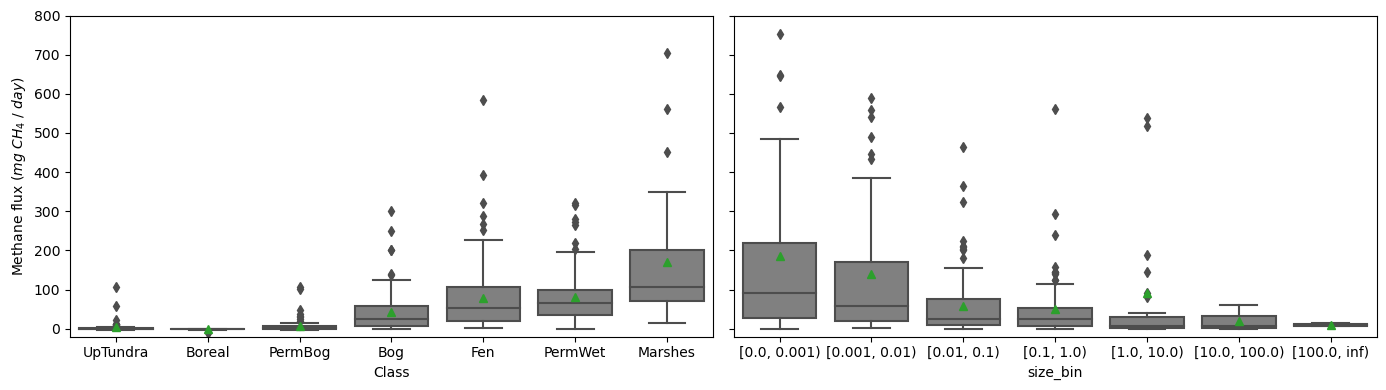

In [24]:
## Plot by size bin, instead of lake type
df['size_bin'] = pd.cut(df['SA'], [0, 0.001, 0.01, 0.1, 1, 10, 100, np.inf], right=False)
fig, ax = plt.subplots(1,2, sharey=True, figsize=(14, 4))
sns.boxplot(df_terr, x='Class', y='CH4Av', ax=ax[0], color='grey', showmeans=True)
sns.boxplot(dff, x='size_bin', y='CH4.DE.FLUX', ax=ax[1], color='grey', showmeans=True) # x='labels'

## ylim
ax[0].set_ylim([-20, 800])

## labels
ax[0].set_ylabel('Methane flux ($mg\ CH_4\ /\ day$)')
ax[1].set_ylabel('')
# ax[1].set_xticklabels(['Glacial\npostglacial', 'Thermokarst', 'Peatland\nPond', 'Beaver\nPond', 'Unspecified'])
# ax[1].set_xticklabels(['Thermokarst', 'Glacial\npostglacial', 'Beaver\nPond', 'Peatland\nPond', 'Unspecified'])
fig.set_tight_layout(tight=True)

In [46]:
## Smallest lakes
print(f"Median flux from lakes < 0.001 km2: {dff[dff.size_bin == pd.Interval(0, 0.001, closed='left')]['CH4.DE.FLUX'].median():0.3}")
print(f"Mean flux from lakes < 0.001 km2: {dff[dff.size_bin == pd.Interval(0, 0.001, closed='left')]['CH4.DE.FLUX'].mean():0.4}")

## Lakes near HL cutoff
print('')
print(f"Median flux from lakes ~ 1 km2: {dff[dff.size_bin == pd.Interval(0.1, 1, closed='left')]['CH4.DE.FLUX'].median():0.3}")
print(f"Mean flux from lakes ~ 1 km2: {dff[dff.size_bin == pd.Interval(0.1, 1, closed='left')]['CH4.DE.FLUX'].mean():0.4}")

Median flux from lakes < 0.001 km2: 90.6
Mean flux from lakes < 0.001 km2: 185.8

Median flux from lakes ~ 1 km2: 23.7
Mean flux from lakes ~ 1 km2: 51.02


In [60]:
## Method 2 for marsh:ow ratio
print(f"Flux ratio (Marsh:OW, method 2): {marshes['CH4Av'].median()/(dff['CH4.DE.FLUX'].median()):0.3}") # uses, D,E +/or combined DEP chamber flux
print(f"Median ow: {dff['CH4.DE.FLUX'].median():0.3}")
print(f"Mean ow: {dff['CH4.DE.FLUX'].mean():0.4}")
print(f"Median marsh: {marshes['CH4Av'].median():0.4}")
print(f"Mean marsh: {marshes['CH4Av'].mean():0.4}")

Flux ratio (Marsh:OW, method 2): 3.67
Median ow: 28.9
Mean ow: 100.9
Median marsh: 106.0
Mean marsh: 171.6


## Rosentreter data
https://figshare.com/articles/dataset/Aquatic_methane_flux_database/13611296

In [79]:
df = pd.read_excel('/Volumes/thebe/Other/Rosentreter2021/Rosentreter_aquatic_ecosystems_database.xlsx', sheet_name='lakes, ponds and reservoirs', skiprows=29, nrows=314)
df.head(3)

,reference_number,site_name,country,type,lat,long,elevation_m,surface_area_km2,depth_max_m,depth_mean_m,...,TP_mgl,trophic_status,CH4_umoll,fch4_mgCH4m2d,dfch4_mgCH4m2d,efch4_mgCH4m2d,References for Chlorophyll Source,Ebullition method(s),Diffusion method(s),Reference
0,1,1,Sweden,Lake,68.346625,18.969453,NaN,0.000029,0.21,NaN,...,NaN,NaN,9.506569,394.409113,55.701011,338.708102,NaN,static chambers,static chambers,Kuhn et al. 2018
1,1,2,Sweden,Lake,68.346514,18.969567,NaN,0.000006,0.16,NaN,...,NaN,NaN,35.845913,200.442928,160.986803,39.456124,NaN,static chambers,static chambers,Kuhn et al. 2018
2,1,3,Sweden,Lake,68.346378,18.969494,NaN,0.000020,0.21,NaN,...,NaN,NaN,6.311748,147.983328,28.981024,119.002303,NaN,static chambers,static chambers,Kuhn et al. 2018


First, try to replicate summary stats from Rosentreter et al. 2021: \
All lakes
```
Median: 55.8 (23.3–142.3)
Mean: 150.9 ± 73.0
```

My values are close enough... \
My CI roughly matches bottom, but is too low on top.

In [127]:
## Replicate means and medians from paper
# df.columns
data_summary = df.fch4_mgCH4m2d.describe(percentiles=[0.05, 0.95]) # mgCH4 /m2 /day
data_summary = pd.concat((data_summary, pd.Series(df.fch4_mgCH4m2d.sem(), index=['sem'])))
data_summary

## SEM
# data_summary['std'] / np.sqrt(data_summary['count']) # double-check SEM

## CI
from scipy import stats
data_summary['sem'] * stats.t.ppf((1 + 0.95) / 2, data_summary['count'] - 1)

35.05404727625348

<AxesSubplot:xlabel='fch4_mgCH4m2d', ylabel='Count'>

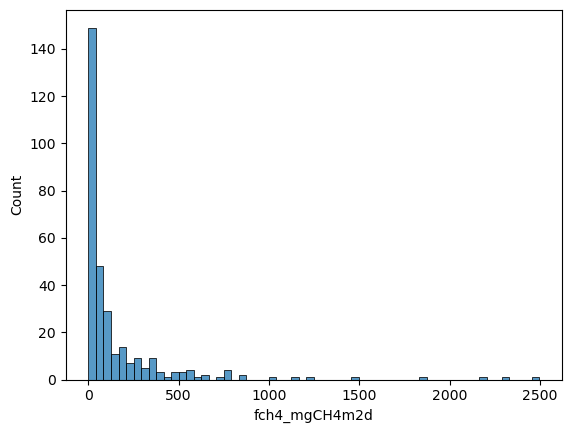

In [126]:
## Plot
# df.fch4_mgCH4m2d.plot.hist()
# sns.histplot(df, x='surface_area_km2',y='fch4_mgCH4m2d')
sns.histplot(df, x='fch4_mgCH4m2d')

## Apply models

In [6]:
## I/O This file is the output of QGIS join nearest and when there are multiple nearest BAWLD grid cells (didst 0) to a large lake, multiple rows are created.
## Loading is actually quicker w/o using a bounding box or mask!
# gdf = read_dataframe(gdf_pth, columns=['OBJECTID', 'Shape_Area', 'BAWLDCell_', 'BAWLDLong', 'BAWLDLat'], read_geometry=False, use_arrow=True) # pyogrio.read_dataframe(path_or_buffer, /, layer=None, encoding=None, columns=None, read_geometry=True, force_2d=False, skip_features=0, max_features=None, where=None, bbox=None, fids=None, sql=None, sql_dialect=None, fid_as_index=False, use_arrow=False)
if isinstance(gdf_pth, str): # if loading from single file
    dgdf = dgpd.read_file(gdf_pth, columns=list(variables.values())+['geometry'], chunksize=10000) # add geometry if doing spatial join
elif isinstance(gdf_pth, list): # list of files
    dgdf = dgpd.read_file(gdf_pth[0], columns=list(variables.values())+['geometry'], chunksize=10000)\
        .append(dgpd.read_file(gdf_pth[1], columns=list(variables.values())+['geometry'], chunksize=10000))\
        .append(dgpd.read_file(gdf_pth[2], columns=list(variables.values())+['geometry'], chunksize=10000)) # add geometry if doing spatial join    
else:
    raise ValueError("gdf_pth must be a str or list")


In [7]:
## Load ROI
if useROI:
    roi = gpd.read_file(roi_pth)
    if 'PAD2019' in roi_pth: # PAD ROIs have multiple features in layer
        roi.query('Region == @roi_region', inplace=True)
        roi.crs = 'ESRI:102001' # only needed if loading UAVSAR 
    # if roi.crs.to_epsg() != 4326:
    #     roi = roi.to_crs('EPSG:4326')
    if not roi.crs.is_exact_same(dgdf.crs):
        roi =roi.to_crs(dgdf.crs)
else:
    roi = None

## Continue

In [8]:
## Clip to ROI (note clip function actually clips the geometries)
# dgdf = dgpd.sjoin(dgdf, roi) # calling function from dask_geopandas doesn't work because it uses sjoin from dask, not from geopandas...
if roi is not None:
    cols = dgdf.columns
    dgdf = dgdf.sjoin(roi, how='inner')[np.unique(list(cols) + list(variables.values()))].drop_duplicates(variables['id_']) # only keep orig columns, note that sjoin can produce extra features if one-to-many
# gdfHL.plot()

## view (slow if I have to merge or drop duplicates first)
# gdf.head()
# dgdf.head()

### Side Workflow: Testing with parquet speed

In [9]:
## Save as parquet
gdfHL = dgpd.read_file('/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp', columns=['Hylak_id', 'Shp_Area', 'BAWLDCell_', 'geometry'],
    chunksize=5000)

In [10]:
# gdfHL.clip(roi)
type(gdfHL)
# gdfHL.clip?
gdfHL.calculate_spatial_partitions()

In [ ]:

dgpd_clip = dgpd.clip(gdfHL, roi)
dgpd_clip.compute()

/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. T

,BAWLDCell_,Hylak_id,Shp_Area,geometry
6383,8442,3948,38.66,"POLYGON ((-114.06058 62.58021, -114.06557 62.5..."
6384,8443,3948,38.66,"POLYGON ((-114.06058 62.58021, -114.06557 62.5..."
6394,8442,3956,36.52,"POLYGON ((-114.25825 62.66982, -114.25536 62.6..."
6338,8442,3917,24.75,"MULTIPOLYGON (((-114.20183 62.76192, -114.2011..."
546423,7907,558888,0.78,"POLYGON ((-114.13635 62.33231, -114.13660 62.3..."
...,...,...,...,...
57,7387,3,26734.29,"MULTIPOLYGON (((-114.34862 62.42650, -114.3476..."
104,7912,3,26734.29,"MULTIPOLYGON (((-114.34862 62.42650, -114.3476..."
102,7911,3,26734.29,"MULTIPOLYGON (((-114.34862 62.42650, -114.3476..."
97,8440,3,26734.29,"MULTIPOLYGON (((-114.34862 62.42650, -114.3476..."


In [ ]:
dgpd_clip

,BAWLDCell_,Hylak_id,Shp_Area,geometry
npartitions=8,,,,
,int64,int64,float64,geometry
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [ ]:
## Test write to parquet
parquet_out_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/test/HL_zStats_Oc_binned_jnBAWLD_Baker_clip_parquet'
dgpd_clip.to_parquet(parquet_out_pth)
# dgpd_clip.to_parquet?

/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. T

In [ ]:
## Test read parquet file
foo2 = dgpd.read_parquet([f'{parquet_out_pth}/part.{i}.parquet' for i in range(8)])
foo2


TypeError: An error occurred while calling the read_parquet method registered to the pandas backend.
Original Message: GeoArrowEngine._create_dd_meta() takes 2 positional arguments but 3 were given

### Test: Join in climate data from WorldClim using pypi package latlon_utils 
(netcdf is in ~/.local/share/latlon_utils/)

In [ ]:
## Join in BAWLD attributes
gdfBAWLD = gpd.read_file('/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip')
gdfHL = gdfHL.merge(gdfBAWLD[['Cell_ID', 'Long', 'Lat']], left_on='BAWLDCell_', right_on='Cell_ID')

gdfHL.head(3)

,0-5,5-50,50-95,95-100,Class_sum,Shp_Area,BAWLDCell_,n,distance,feature_x,...,nearest_x,nearest_y,geometry,index_right,id,Region,Note,Cell_ID,Long,Lat
0,0.232737,0.198573,4.089538,95.479152,26893.426,26734.29,7387,1,0.0,-113.000000,...,-113.000000,61.500000,"POLYGON ((-109.93976 62.95851, -109.93831 62.9...",2,1,Baker,Baker - outermost,7387,-113.25,61.75
1,4.258225,4.744306,86.522316,4.475154,24.893,24.75,8442,1,0.0,-114.134654,...,-114.134654,62.852126,"POLYGON ((-114.13465 62.85213, -114.13516 62.8...",2,1,Baker,Baker - outermost,8442,-114.25,62.75
2,2.601877,2.470755,34.824528,60.102841,38.895,38.66,8442,1,0.0,-114.000000,...,-114.000000,62.576271,"POLYGON ((-113.95252 62.61332, -113.95139 62.6...",2,1,Baker,Baker - outermost,8442,-114.25,62.75


### Side workflow: Apply to BAWLD lakes to use as lookup table (don't need for main workflow)


#### Side workflow for gap-filling worldclim Temp netcdf so ocean cells take nearest land value

In [28]:
## Fall 2023 fix for worldclim xarray error: download manually:
!curl -o {latlong_utils_data_dir}/wc2.1_10m_tavg.zip https://data.biogeo.ucdavis.edu/data/worldclim/v2.1/base/wc2.1_10m_tavg.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35.6M  100 35.6M    0     0  2809k      0  0:00:12  0:00:12 --:--:-- 6406k16  0:00:11  0:00:05 4260k


In [29]:
## Verify NaNs in worldclim over oceans
get_climate(80.25, 16.25)

Extracting /var/folders/rv/sn0kln2103b9fs4xl56n3w7w0000gn/T/worldclim_3g9bvgnm/wc2.1_10m_tavg.zip


AttributeError: module 'xarray' has no attribute 'open_rasterio'

In [25]:
import latlon_utils
latlon_utils.get_data_file
get_data_dir
latlong_utils_data_dir

'/Users/ekyzivat/.local/share/latlon_utils'

In [2]:
## Load worldclim data
latlong_utils_data_dir = get_data_dir()
da = xr.load_dataset(os.path.join(latlong_utils_data_dir, 'tavg_10m.nc'))

## View
da

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ekyzivat/.local/share/latlon_utils/tavg_10m.nc'

In [ ]:
## Practice selecting with dask
da
# da.tavg[89.92, -179.9, 2]
# daa = xr.DataArray(da)
# da.tavg[3,0,0]
da.tavg.sel(lat=[89.92, 89.75], lon=[-179.9, -179.8], month=1, method='nearest')
# da.tavg.loc[0, 89.92, -179.9]

<xarray.DataArray 'tavg' (lat: 2, lon: 2)>
array([[-inf, -inf],
       [-inf, -inf]], dtype=float32)
Coordinates:
    band     int64 1
  * lat      (lat) float64 89.92 89.75
  * lon      (lon) float64 -179.9 -179.8
    month    int64 1
Attributes:
    transform:      [ 1.66666667e-01  0.00000000e+00 -1.80000000e+02  0.00000...
    crs:            +init=epsg:4326
    res:            [0.16666667 0.16666667]
    is_tiled:       0
    nodatavals:     -3.3999999521443642e+38
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area
    long_name:      maximum temperature
    units:          degC
    history:        2023-02-03T17:04:07.722449: Downloaded tavg data with lat...
    reference:      Fick, S.E. and R.J. Hijmans, 2017. Worldclim 2: New 1-km ...

I tried using xarray.DataSet.interpolate_na, but it only works in one dim... from scipy.interpolate import NearestNDInterpolator was too complicated

In [ ]:
## Convert -inf to nan to enable filling
ds_masked = da.where(da['tavg'] != -np.inf)

## Verify
ds_masked.tavg

<xarray.DataArray 'tavg' (month: 12, lat: 1080, lon: 2160)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-18.87976 , -19.53003 , -19.530762, ..., -21.501526,
         -21.49524 , -20.174744],
        [-16.98999 , -17.919983, -17.919983, ..., -19.73999 ,
         -19.732727, -18.200256],
        [-17.273499, -17.862488, -17.880005, ..., -19.684753,
         -19.672241, -18.494019]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-24.55603 , -25.22998 , -25.231262, ..., -27.825012,
         -27.812988, -26.461243],
        [-22.179016, -23.252502, -23.26001 , ..., -25.646729,
         -25.63324 , -23.947754],
        [-22.613281, -23.225525, -23.22998 , ..., -25.619995,
         -25.609741, -24.393982]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-18.36023 , -19.015015, -19.015259, ..., -21.083496,
         -21.067505, -19.755249],
        [-16.507263, -17.432007, -17.437256, ..., -19.330017,
         -19.327515, -17.807983],
        [-16.775513, -17.360779, -17.37378 , ..., -19.295471,
         -19.279724, -18.091003]]], dtype=float32)
Coordinates:
    band     int64 1
  * lat      (lat) float64 89.92 89.75 89.58 89.42 ... -89.58 -89.75 -89.92
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.8 179.9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    transform:      [ 1.66666667e-01  0.00000000e+00 -1.80000000e+02  0.00000...
    crs:            +init=epsg:4326
    res:            [0.16666667 0.16666667]
    is_tiled:       0
    nodatavals:     -3.3999999521443642e+38
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area
    long_name:      maximum temperature
    units:          degC
    history:        2023-02-03T17:04:07.722449: Downloaded tavg data with lat...
    reference:      Fick, S.E. and R.J. Hijmans, 2017. Worldclim 2: New 1-km ...

In [ ]:
## Fill nans using rio
ds_masked2 = ds_masked.tavg.rio.set_spatial_dims('lon','lat', inplace=False) # inplace doesn't work
ds_masked2.rio.write_nodata(np.nan, inplace=True)
filled = ds_masked2.rio.interpolate_na()

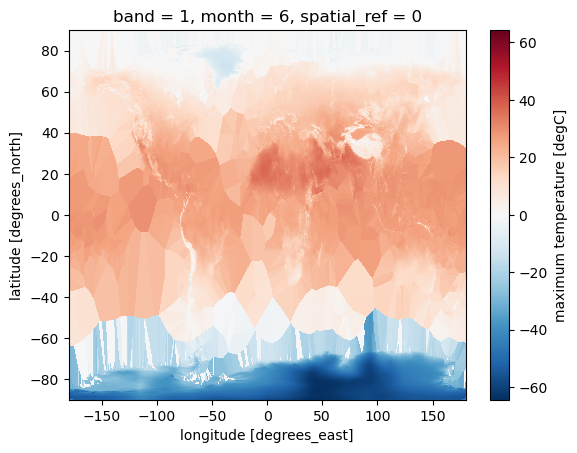

In [ ]:
## Save back to array
da['tavg'] = filled

## Plot
da.tavg.sel(month=6).plot.imshow()

## save
da.to_netcdf(os.path.join(latlong_utils_data_dir, 'tavg_10m_filled.nc'))

#### Apply to BAWLD lakes to use as lookup table (don't need for this workflow)


In [ ]:
## Load
dgdfBAWLD = dgpd.read_file('/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip', chunksize=1000)


In [ ]:
## partitions
dgdfBAWLD.calculate_spatial_partitions()

In [ ]:
## Map function
BAWLD_clim = dgdfBAWLD.map_partitions(applyGet_climate).compute()


In [ ]:
## Join in BAWLD ID
BAWLD_clim_jn = pd.concat((BAWLD_clim.reset_index(), dgdfBAWLD['Cell_ID'].compute()), axis=1) # for some reason, just re-assigning column doesn't work


In [ ]:
## Write out
# BAWLD_clim_jn.to_file('/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD/edk_out/BAWLD_V1___Shapefile_jn_clim.shp')
BAWLD_clim_jn.to_csv('/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD/edk_out/BAWLD_V1___Shapefile_jn_clim.csv')
print('Files written.')

Files written.


### Computing temperature means for each lake

In [ ]:
## Again dask-ify and chunk (I had to compute earlier to return groupby results to speed up future computations)
# ddf_HL = dd.from_pandas(gdfHL, chunksize=10000) 
# dgdf = dgpd.from_geopandas(gdf, chunksize=10000) # assume default sorting provides geosptial partitions, not that it shold matter

In [ ]:
## Def functions
def applyGet_climate(ddf):
    '''ddf needs to have 'Lat' and 'Long' attributes'''
    return get_climate(ddf.loc[:, [variables['lat_']]].to_numpy().T.tolist()[0], ddf.loc[:, [variables['long_']]].to_numpy().T.tolist()[0],
        variables = ['tavg'], data_files=['/home/ekyzivat/.local/share/latlon_utils/tavg_10m_filled.nc'], load_data=True)['tavg'] # data_files='/home/ekyzivat/.local/share/latlon_utils/tavg_10m.nc' _filled 

## Test
# applyGet_climate(dgdf[:100].compute())
# applyGet_climate(dgdf.partitions[0]).compute()

In [ ]:
## Quicker lookup function
clim_cols = ['djf','mam','jja','son','ann', 'lat', 'lon']
def lookup_climate(ddf):
    '''ddf and loaded LUT needs to have 'Lat' and 'Long' attributes'''
    lut = pd.read_csv('/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD/edk_out/BAWLD_V1___Shapefile_jn_clim.csv', usecols=clim_cols) # lookup table
    
    ## Join on lat/long
    joined = ddf.merge(lut, 'left', left_on=[variables['lat_'], variables['long_']], right_on=['lat', 'lon']) # for some reason, output retains both lat/long index pairs...
    # validate = 'one_to_one')
    return joined.drop(columns=[variables['lat_'], variables['long_']]) # return joined[climate cols]

## Test
# res = lookup_climate(dgdf.partitions[0]).compute() # lookup_climate(dgdf[:100].compute())
# res

In [ ]:
## Apply
# df_HL_clim = ddf_HL.apply(applyGet_climate, axis=1)
# HL_clim = ddf_HL.map_partitions(applyGet_climate).compute()
meta = dict(zip([variables['id_'], variables['gridcell_'], variables['area_'], variables['long_'], variables['lat_']] + clim_cols, [float] + [int] + [float]*11)) # metadata for dask mapping # list(variables.values())
dgdf_clim = dgdf.map_partitions(lookup_climate, meta=meta, enforce_metadata=False).compute()

## View
dgdf_clim.head(3)

,Cell_ID,SID,area,geometry,lat,lon,djf,mam,jja,son,ann
0,477,NA1,1.531095e+04,"POLYGON ((4366588.138 291203.365, 4366616.274 ...",49.75,-86.25,-16.347249,-0.547831,14.784729,2.883158,0.193202
1,477,NA2,4.693504e+06,"POLYGON ((4358818.390 267211.173, 4358874.680 ...",49.75,-86.25,-16.347249,-0.547831,14.784729,2.883158,0.193202
2,477,NA3,1.711258e+04,"POLYGON ((4368785.517 283314.697, 4368813.653 ...",49.75,-86.25,-16.347249,-0.547831,14.784729,2.883158,0.193202


## Verify, join

In [ ]:
## Shortcut: load saved data!
if not 'dgdf_clim' in locals():
    dgdf_clim = pd.read_csv(summ_file_pth)
    print(f'Loading dgdf_clim from path: {summ_file_pth}')

In [ ]:
## Check that order is preserved in HL_clim (slow if using dask)
# np.all(dgdf_clim.reset_index()[['lat','lon']].to_numpy() == dgdf[[variables['lat_'], variables['long_']]].compute().to_numpy()) # 

In [ ]:
## Check for duplicates # this was only possible when I had forgotten to groupby id and take first to drop duplicates in early step
dups = len(dgdf_clim[variables['id_']]) - len(dgdf_clim[variables['id_']].drop_duplicates())
if dups >0:
    print(f"Warning: {dups} duplicate {variables['id_']} found!")
    
    ## Drop duplicates! (Why were these there?...)
    dgdf_clim.drop_duplicates(subset=variables['id_'], inplace=True)

Text(0.5, 1.0, 'Sheng grid temperatures in BAWLD_WBD-NAHL domain')

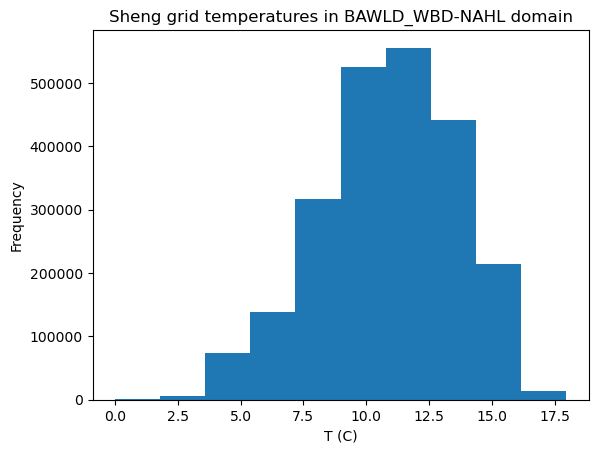

In [ ]:
## Verify temp scale
dgdf_clim.jja.plot.hist()
plt.xlabel('T (C)')
plt.title(f'{dataset} grid temperatures in {roi_region} domain')

Text(0.5, 1.0, 'Sheng lakes in BAWLD_WBD-NAHL domain')

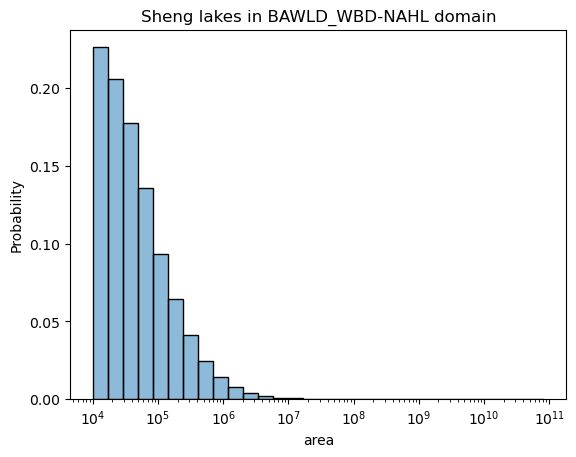

In [ ]:
## View distrib of lake areas indataset
# HL_clim_jn.Shp_Area.plot.hist()
sns.histplot(data=dgdf_clim, x=variables['area_'], element="bars", log_scale=True, bins=30, palette=None, stat='probability', cumulative=False, common_norm=False, fill=True, alpha=0.5) # 
plt.title(f'{dataset} lakes in {roi_region} domain')

# Archived

## Apply methane prediction and write out

In [6]:
## Todo: convert these to class and methods!
def predictFlux(df, model, area_var, season, areaConversionFactor=areaConversionFactor):
    '''
    Uses pre-existing variable names from 'model' and existing 'areaConversionFactor'.
    Note that areaConversionFactor doesn't rescale area units (for now)
    '''
    ## Flux (areal, gCH4/m2/day)
    df['Est_mg_m2_day'] = 10**(model1.params.Intercept +
    model1.params['np.log10(SA)'] * np.log10(df[area_var] / areaConversionFactor) 
    + model1.params['TEMP'] * df[season]) # jja, ann, son, mam

    ## Flux (flux rate, gCH4/day)
    df['Est_g_day'] = df.Est_mg_m2_day * df[area_var] * 1e3  / areaConversionFactor# (convert km2 -> m2 and mg -> g)

    ## Rescale area units (not backwards compatible, so careeful)
    # df[area_var] = df[area_var] / areaConversionFactor
    return df

def sumFluxesAreas(df, area_var, areaConversionFactor=areaConversionFactor, maxArea=maxArea, minArea=0):
    '''
    Uses existing var areaConversionFactor and maxArea
    Returned lake_area_used is in km2
    '''
    ## Sum! (Tg /yr)
    estSum = df.query(f"(@minArea * @areaConversionFactor) <= {area_var} < (@maxArea * @areaConversionFactor)")['Est_g_day'].sum() * 365.25 / 1e12
    lake_area_used = df.query(f"(@minArea * @areaConversionFactor) <= {area_var} < (@maxArea * @areaConversionFactor)")[area_var].sum() / areaConversionFactor
    return estSum, lake_area_used

## Test
# foo = predictFlux(dgdf_clim, model1, variables['area_'], season)
# estSum1, lake_area_used1 = sumFluxesAreas(foo, variables['area_'])
# print(f'Emissions in BAWLD domain: {estSum1:.3} Tg/yr')
# print(f"Lake area used: {lake_area_used1:.4} km2")

In [ ]:
def predictIfNeeded(df):
    ''' Runs 'predictFlux to create a Est_g_day' column, if not already present.'''
    if not 'Est_g_day' in df.columns:
        print('Creating estimate...')
        df = predictFlux(df, model1, 'Shp_Area', season, areaConversionFactor=1)
    return df

In [ ]:
## Apply function
dgdf_clim = predictFlux(dgdf_clim, model1, variables['area_'], season)

## View
# HL_clim_jn['Est_mg_m2_day'].head()
# HL_clim_jn['Est_g_day'].head()


## Sum fluxes and areas
estSum, lake_area_used = sumFluxesAreas(dgdf_clim, variables['area_'])
with open(logFile_pth, 'w') as f:
    print(f'Run number: {run}\nDataset: {dataset}\nROI: {roi_region}\nSeason: {season}\nMax lake area used: {maxArea:,}', file=f)
    print(f'Number of lakes: {len(dgdf_clim):,}', file=f)
    print(f'NOTES: {runNote}\n', file=f)
    print(f'Emissions in BAWLD domain: {estSum:.3} Tg/yr', file=f)
    print(f"Lake area used: {lake_area_used:.4} km2", file=f)
with open(logFile_pth, 'r') as f:
    lines = f.read()
    print(lines)

Run number: 8
Dataset: Sheng
ROI: BAWLD_WBD-NAHL
Season: jja
Max lake area used: 5,000
Number of lakes: 2,288,595
NOTES: HL in BAWLD-WBD domain for comparison

Emissions in BAWLD domain: 0.805 Tg/yr
Lake area used: 5.072e+05 km2



In [ ]:
## Write out dataframe
# dgdf_clim.to_csv(os.path.join(joined_clim_dir, f'{dataset}_sub{roi_region}_clim_full.csv')) # not needed / too big!
dgdf_clim[[variables['id_'], variables['area_'], 'lat', 'lon', 'djf', 'mam','jja','son','ann', 'Est_mg_m2_day', 'Est_g_day']].to_csv(summ_file_pth)
print(f'Wrote file: {summ_file_pth}')

Wrote file: /mnt/g/Ch4/GSW_zonal_stats/HL/v3/joined_climate/run08/Sheng_subBAWLD_WBD-NAHL_clim_summ.csv


In [ ]:
## Preview file
!head {summ_file_pth}

,SID,area,lat,lon,djf,mam,jja,son,ann,Est_mg_m2_day,Est_g_day
0,NA1,15310.949462890625,49.75,-86.25,-16.347249348958332,-0.5478312174479166,14.78472900390625,2.8831583658854165,0.1932017008463541,14.21716068066549,217.67822868746498
1,NA2,4693503.744628906,49.75,-86.25,-16.347249348958332,-0.5478312174479166,14.78472900390625,2.8831583658854165,0.1932017008463541,5.771006774173016,27086.241904859835
2,NA3,17112.577880859375,49.75,-86.25,-16.347249348958332,-0.5478312174479166,14.78472900390625,2.8831583658854165,0.1932017008463541,13.970267540285215,239.06729129957247
3,NA4,15311.253662109375,49.75,-86.25,-16.347249348958332,-0.5478312174479166,14.78472900390625,2.8831583658854165,0.1932017008463541,14.217116199516258,217.6818724744778
4,NA5,617858.4929199219,49.75,-86.25,-16.347249348958332,-0.5478312174479166,14.78472900390625,2.8831583658854165,0.1932017008463541,7.941920261092514,4906.982883408814
5,NA6,167525.95397949216,49.75,-86.25,-16.347249348958332,-0.5478312174479166,14.7847

## Hybrid estimate for NAHL domain

In [2]:
## load three estimates
df_hl = pd.read_csv('/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/joined_climate/run03/HL_subWBD_clim_jja.csv')
df_sheng = pd.read_csv('/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/joined_climate/run08/Sheng_subWBD_BAWLD_clim_summ.csv')
df_wbd = pd.read_csv('/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/joined_climate/run04/WBD_subWBD_BAWLD_clim_summ.csv')

In [3]:
df_hl.head(3)
# df_sheng.head(3)
# df_wbd.head(3)
# areaConversionFactor

,Unnamed: 0,Hylak_id,jja,Shp_Area
0,0,2,11.148844,30450.64
1,1,3,12.582336,26734.29
2,2,4,16.863505,23923.04


In [13]:
## Predict, if needed: Update df_hl (the only one who needs it)
df_hl, df_sheng, df_wbd = list(map(predictIfNeeded, (df_hl, df_sheng, df_wbd)))

Creating estimate...


In [14]:
## Predict x3
estSum_hl, lake_area_used_hl = sumFluxesAreas(df_hl, 'Shp_Area', areaConversionFactor=1, maxArea=np.inf, minArea=0.1)
estSum_sheng, lake_area_used_sheng = sumFluxesAreas(df_sheng, 'area', areaConversionFactor=1e6, maxArea=0.1, minArea=0.01)
estSum_wbd, lake_area_used_wbd = sumFluxesAreas(df_wbd, 'Area', areaConversionFactor=1, maxArea=0.01, minArea=0)

[746137.7599999998, 805675.0937146356, 819091.9657548245]


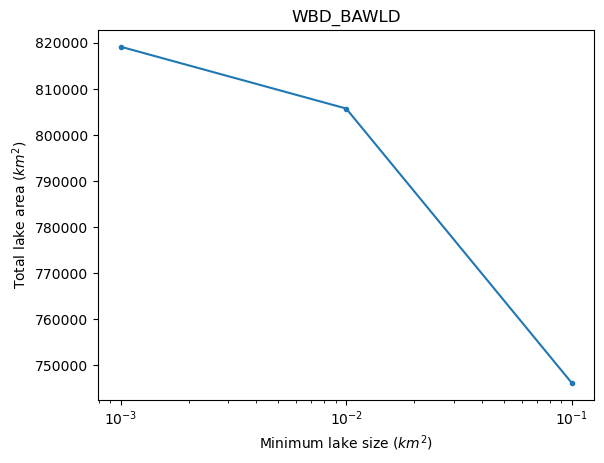

In [27]:
## Plot
bin0sum = lake_area_used_hl
bin1sum = lake_area_used_sheng + lake_area_used_hl
bin2sum = lake_area_used_sheng + lake_area_used_hl + lake_area_used_wbd

## print vars for easy copying
print(f'{[bin0sum, bin1sum, bin2sum]}')
plt.plot([0.1, 0.01, 0.001], [bin0sum, bin1sum, bin2sum], '.-')
plt.xscale('log')
plt.xlabel('Minimum lake size ($km^2$)')
plt.ylabel('Total lake area ($km^2$)')
plt.title(roi_region)
plt.show()

## Troubleshooting Sheng

In [ ]:
dgdf.total_bounds.compute() 
''' array([-4315529.9428    , -4216258.90743544,  4976675.09842979,
        3369282.5988    ])'''

# format = minx, miny, maxx, maxy
# y, x min: -4216258.90743544, -4315529.9428    : GEOG: 33.47694881, 134.33336903
# y, x max: 3369282.5988, 4976675.09842979 : GEOG: 33.71528489, -55.90141904 ??


array([-4315529.9428    , -4216258.90743544,  4976675.09842979,
        3369282.5988    ])

In [ ]:
import pyogrio
gdf = dgdf.compute()
pyogrio.write_dataframe(gdf, '/Volumes/thebe/Other/Sheng-Arctic-lakes/edk_out/UCLA_ArcticLakes15_cmb.shp')

Warning 1: Value 31958511907.5820312 of field area of feature 566 not successfully written. Possibly due to too larger number with respect to field width
Warning 1: Value 4619105503.34786987 of field area of feature 639 not successfully written. Possibly due to too larger number with respect to field width
Warning 1: Value 650874317.066195607 of field area of feature 674 not successfully written. Possibly due to too larger number with respect to field width
Warning 1: Value 114848457.08203125 of field area of feature 1287 not successfully written. Possibly due to too larger number with respect to field width
Warning 1: Value 175108650.353637695 of field area of feature 1624 not successfully written. Possibly due to too larger number with respect to field width
Warning 1: Value 242955459.452209473 of field area of feature 1633 not successfully written. Possibly due to too larger number with respect to field width
Warning 1: Value 143140926.493382931 of field area of feature 1638 not suc

In [ ]:
## For example, this feature is not in the combined shapefile I wrote out...
gdf.query('OBJECTID == 110971')

,Cell_ID,Lat,Long,OBJECTID,area,geometry
110970,14989,68.25,17.25,110971.0,89150.39917,"POLYGON ((-714447.596 2281213.055, -714330.171..."


## TODO:
* apply get_climate function over all hydrolakes using BAWLD cell lat/long X
    * Or, if worldclim netcdf is fine-scale, use individual lake lat/long
* Smart dask way is to define an entire processing chain that ends with writing out X
* Apply upscaling calc using lake area (Shp_area) and summer temp X
* If redo-ing, 
    * use lake centroid, and then no need to join to BAWLD (and slightly more nuanced, HR temp data)
    * Apply 'meta' argument to map_partitions to increase speed....
* C or K? X
* Plot, sum, profit!
* Don't need QGIS join, just use sjoin in gpd!

In [70]:
import dbfread

ModuleNotFoundError: No module named 'dbfread'

## Troubleshooting

In [ ]:
from pyogrio import read_dataframe
gdf = read_dataframe(gdf_pth, columns=['OBJECTID', 'Area', 'ID'], read_geometry=True, use_arrow=True) # pyogrio.read_dataframe(path_or_buffer, /, layer=None, encoding=None, columns=None, read_geometry=True, force_2d=False, skip_features=0, max_features=None, where=None, bbox=None, fids=None, sql=None, sql_dialect=None, fid_as_index=False, use_arrow=False)

In [ ]:
gdf.shape

(6652015, 4)

In [ ]:
gdfJ = gdf.sjoin(roi, how='inner')

In [ ]:
gdfJ.shape

(6692998, 77)

In [ ]:
gdfJ.columns

Index(['OBJECTID', 'ID', 'Shape_Area', 'geometry', 'index_right', 'Cell_ID',
       'Long', 'Lat', 'Area_Pct', 'Shp_Area', 'GLA', 'ROC', 'TUN', 'BOR',
       'WET', 'PEB', 'WTU', 'MAR', 'BOG', 'FEN', 'LAK', 'LAL', 'MPL', 'MYL',
       'MGL', 'SPL', 'SYL', 'SGL', 'RIV', 'LAR', 'SRR', 'SRP', 'GLA_L',
       'GLA_H', 'ROC_L', 'ROC_H', 'TUN_L', 'TUN_H', 'BOR_L', 'BOR_H', 'WET_L',
       'WET_H', 'PEB_L', 'PEB_H', 'WTU_L', 'WTU_H', 'MAR_L', 'MAR_H', 'BOG_L',
       'BOG_H', 'FEN_L', 'FEN_H', 'LAK_L', 'LAK_H', 'LAL_L', 'LAL_H', 'MPL_L',
       'MPL_H', 'MYL_L', 'MYL_H', 'MGL_L', 'MGL_H', 'SPL_L', 'SPL_H', 'SYL_L',
       'SYL_H', 'SGL_L', 'SGL_H', 'RIV_L', 'RIV_H', 'LAR_L', 'LAR_H', 'SRR_L',
       'SRR_H', 'SRP_L', 'SRP_H', 'WETSCAPE'],
      dtype='object')

In [ ]:
dups = len(gdfJ['OBJECTID']) - len(gdfJ['OBJECTID'].drop_duplicates())
dups

88401

In [ ]:
## Look at dups
dupIdx = gdfJ[np.isin(gdfJ['OBJECTID'], gdfJ['OBJECTID'].drop_duplicates(keep=False), invert=True)].OBJECTID
dupIdx

155            156.0
168            169.0
169            170.0
189            190.0
155            156.0
             ...    
6641997    6641999.0
6652014    6652016.0
6652014    6652016.0
6652014    6652016.0
6652014    6652016.0
Name: OBJECTID, Length: 174219, dtype: float64

In [ ]:
gdfJ.query('OBJECTID == 156')

,OBJECTID,ID,Shape_Area,geometry,index_right,Cell_ID,Long,Lat,Area_Pct,Shp_Area,...,SGL_H,RIV_L,RIV_H,LAR_L,LAR_H,SRR_L,SRR_H,SRP_L,SRP_H,WETSCAPE
155,156.0,173662.0,3.185065e-07,"POLYGON ((-165.99944 54.16296, -165.99950 54.1...",577,1932,-165.75,54.25,21.80,3.963772e+08,...,0.86,0.18,0.46,0.0,0.05,0.02,0.25,0.18,0.52,11
155,156.0,173662.0,3.185065e-07,"POLYGON ((-165.99944 54.16296, -165.99950 54.1...",22530,1931,-166.25,54.25,4.57,8.314832e+07,...,0.63,0.15,0.42,0.0,0.05,0.00,0.35,0.16,0.63,11


In [ ]:
gdf.Area.sum()
# gdfJ.Area.sum()

AttributeError: 'GeoDataFrame' object has no attribute 'Area'